<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>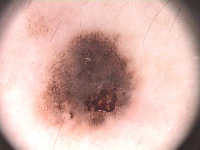</td><td>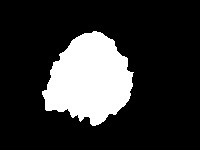</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
#!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

In [ ]:
#!ls

In [ ]:
#get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
from google.colab import drive
drive.mount ('/content/gdrive/',force_remount=True) # монтируем свой GoogleDisc к виртуальной машине

Mounted at /content/gdrive/


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/content/gdrive/MyDrive/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

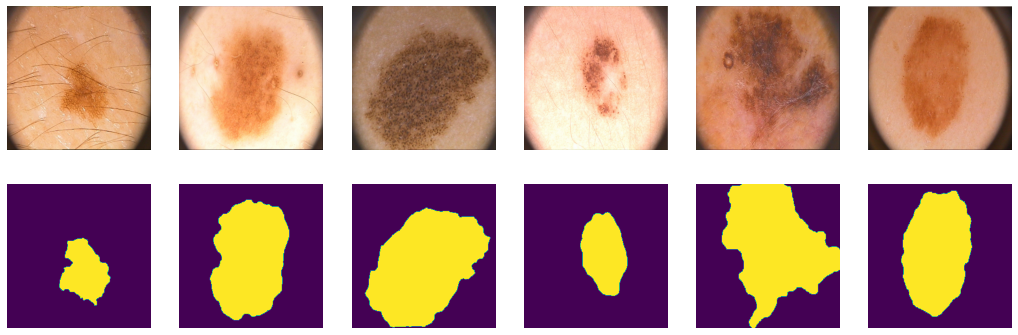

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

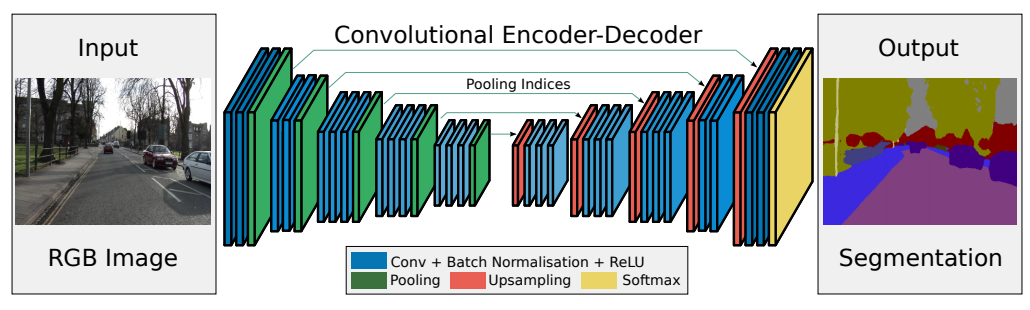

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                        ])
        self.pool0 =  nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                        ])
        self.pool1 =  nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True)# 128 -> 64
        self.enc_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                        ])
        self.pool2 =  nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True)# 64 -> 32
        self.enc_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2), stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv_enc = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])

        self.bottleneck_pool = nn.MaxPool2d(kernel_size=(2,2), stride=2, return_indices=True)

        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.bottleneck_conv_dec = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),     
                                         nn.ReLU()
                                         ])

        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ]) 
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ]) 
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                         ]) 
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
                            
                                         ]) 


    def forward(self, x):
        # encoder

        size_0 = x.size()
        e0, id0 = self.pool0(self.enc_conv0(x))

        size_1 = e0.size()
        e1, id1 = self.pool1(self.enc_conv1(e0))

        size_2 = e1.size()
        e2, id2 = self.pool2(self.enc_conv2(e1))

        size_3 = e2.size()
        e3, id3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        #bottleneck encoder part
        size_4 = e3.size()
        bottle_enc, bottle_id = self.bottleneck_pool(self.bottleneck_conv_enc(e3))
        #bottleneck decoder part
        size_d = bottle_enc.size()
        bottle_dec = self.bottleneck_conv_dec(self.bottleneck_upsample(bottle_enc, bottle_id, output_size=size_4))

        # decoder
        d0 = self.dec_conv0(self.upsample0(bottle_dec, id3, output_size=size_3))
        d1 = self.dec_conv1(self.upsample1(d0, id2, output_size=size_2))
        d2 = self.dec_conv2(self.upsample2(d1, id1, output_size=size_1))
        d3 = self.dec_conv3(self.upsample3(d2, id0, output_size=size_0))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1)
    epsilon = 1e-50
    #result = - torch.mean(
    #    y_real * torch.log(torch.sigmoid(y_pred) + epsilon) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred) + epsilon)
    #)
    result = torch.mean(
        y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred))
        )
    return result


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            # set parameter gradients to zero
            optimizer.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = Y_pred.detach().cpu()# detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        #Y_pred = <TODO>
        Y_pred = model(X_batch.to(device))
        Y_pred = torch.sigmoid(Y_pred)
        Y_pred = torch.where(Y_pred > 0.5, 1, 0)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

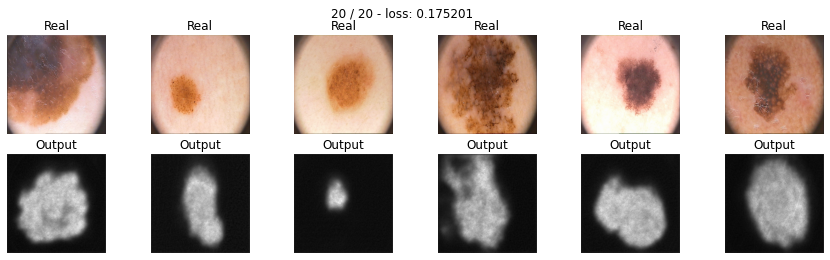

In [ ]:
max_epochs = 20
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.8368408381938934

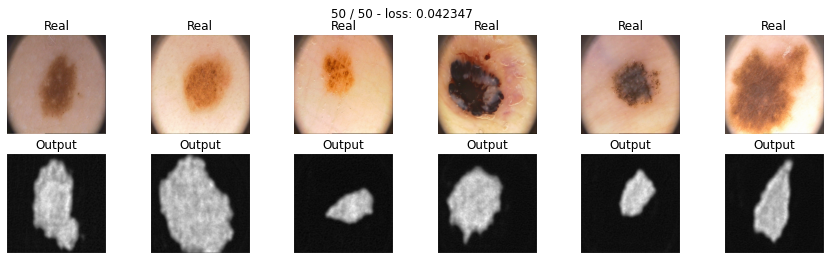

In [ ]:
max_epochs = 50
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.8476022779941559

Ответьте себе на вопрос: не переобучается ли моя модель?


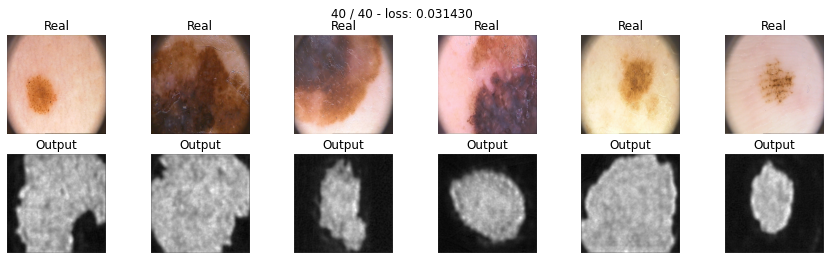

In [ ]:
max_epochs = 40
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.8568695485591888

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    smooth=1e-6
    y_pred = torch.flatten(torch.sigmoid(y_pred))
    y_real = torch.flatten(y_real)
    c = 256**(-2)
    num = 2. * torch.sum(y_pred * y_real)
    den = torch.sum(y_pred + y_real)
    res = torch.mean(
        1. - c*(num+smooth)/(den+smooth)
        )
    return res 

Проводим тестирование:

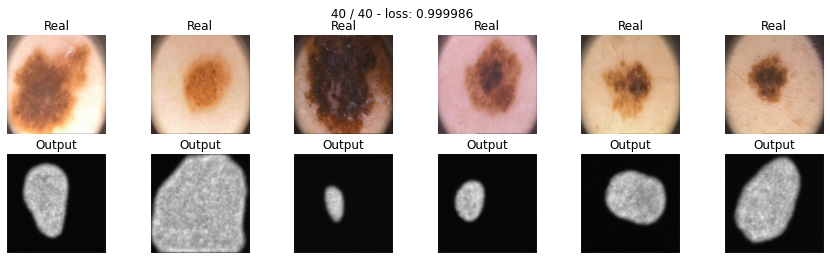

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optim = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
train(model_dice, optim, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.8292828500270844

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1) 
    
    result = -torch.mean(
        ((1 - torch.sigmoid(y_pred)) ** gamma) * y_real * torch.log(torch.sigmoid(y_pred) + eps) + (1 - y_real) * torch.log(
        1 - torch.sigmoid(y_pred) + eps))
    
    return result


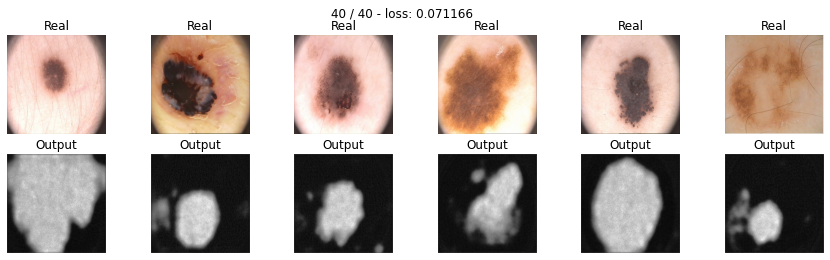

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optim = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
train(model_focal, optim, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.8313444554805756

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

###Binary Hausdorff loss and Binary Tversky loss

In [ ]:
#<TODO>
import cv2
from scipy.ndimage.morphology import distance_transform_edt as edt
from scipy.ndimage import convolve

In [ ]:
class HausdorffDTLoss(nn.Module):
    """Binary Hausdorff loss based on distance transform"""

    def __init__(self, alpha=2.0, **kwargs):
        super(HausdorffDTLoss, self).__init__()
        self.alpha = alpha

    @torch.no_grad()
    def distance_field(self, img: np.ndarray) -> np.ndarray:
        field = np.zeros_like(img)

        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5

            if fg_mask.any():
                bg_mask = ~fg_mask

                fg_dist = edt(fg_mask)
                bg_dist = edt(bg_mask)

                field[batch] = fg_dist + bg_dist

        return field

    def forward(
        self, target: torch.Tensor, pred: torch.Tensor, debug=False
    ) -> torch.Tensor:
        """
        Uses one binary channel: 1 - fg, 0 - bg
        pred: (b, 1, x, y, z) or (b, 1, x, y)
        target: (b, 1, x, y, z) or (b, 1, x, y)
        """
        assert pred.dim() == 4 or pred.dim() == 5, "Only 2D and 3D supported"
        assert (
            pred.dim() == target.dim()
        ), "Prediction and target need to be of same dimension"

        pred = torch.sigmoid(pred)

        pred_dt = torch.from_numpy(self.distance_field(pred.detach().cpu().numpy())).float()
        target_dt = torch.from_numpy(self.distance_field(target.detach().cpu().numpy())).float()

        pred_error = (pred - target) ** 2
        distance = pred_dt ** self.alpha + target_dt ** self.alpha

        dt_field = pred_error.to(device) * distance.to(device)
        loss = dt_field.mean()


        return loss

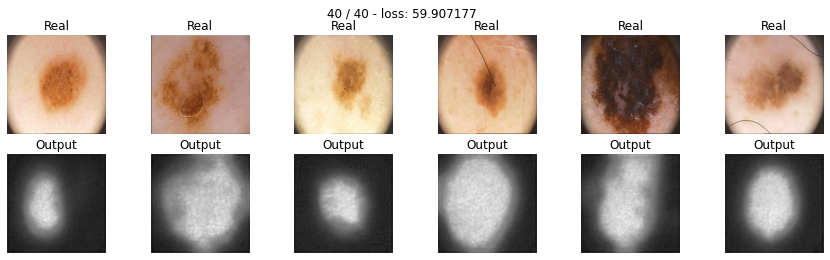

In [ ]:
model_hausdor = SegNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(model_hausdor.parameters(), lr=1e-4)
hausdor_loss = HausdorffDTLoss()
train(model_hausdor, optim, hausdor_loss, max_epochs, data_tr, data_val)


In [ ]:
score_model(model_hausdor, iou_pytorch, data_val)

0.6734614670276642

In [ ]:
class BinaryTverskyLossV2(nn.Module):

    def __init__(self, alpha=0.3, beta=0.7, ignore_index=None, reduction='mean'):
        super(BinaryTverskyLossV2, self).__init__()
        
        self.alpha = alpha
        self.beta = beta
        self.ignore_index = ignore_index
        self.smooth = 10
        self.reduction = reduction
        s = self.beta + self.alpha
        if s != 1:
            self.beta = self.beta / s
            self.alpha = self.alpha / s

    def forward(self, target, output, mask=None):
        batch_size = output.size(0)
        bg_target = 1 - target
        if self.ignore_index is not None:
            valid_mask = (target != self.ignore_index).float()
            output = output.float().mul(valid_mask)  # can not use inplace for bp
            target = target.float().mul(valid_mask)
            bg_target = bg_target.float().mul(valid_mask)

        output = torch.sigmoid(output).view(batch_size, -1)
        target = target.view(batch_size, -1)
        bg_target = bg_target.view(batch_size, -1)

        P_G = torch.sum(output * target, 1)  # TP
        P_NG = torch.sum(output * bg_target, 1)  # FP
        NP_G = torch.sum((1 - output) * target, 1)  # FN

        tversky_index = P_G / (P_G + self.alpha * P_NG + self.beta * NP_G + self.smooth)

        loss = 1. - tversky_index
        # target_area = torch.sum(target_label, 1)
        # loss[target_area == 0] = 0
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        else:
            loss = torch.mean(loss)
        return loss

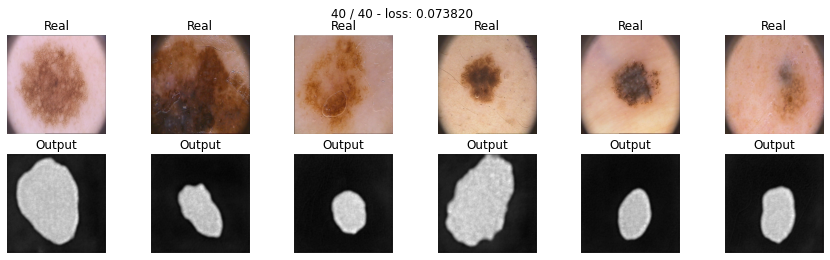

In [ ]:
model_tversky = SegNet().to(device)

max_epochs = 40
optim = torch.optim.Adam(model_tversky.parameters(), lr=1e-4)
tversky_loss = BinaryTverskyLossV2()
train(model_tversky, optim, tversky_loss, max_epochs, data_tr, data_val)


In [ ]:
score_model(model_tversky, iou_pytorch, data_val)

0.8613859415054321

**Численное сравнение лоссов:**

segnet_tversky_loss: 0.8614

segnet_hausdorff_loss: 0.6735

segnet_focal_loss: 0.8313

segnet_dice_loss: 0.8293

segnet_bce_loss: 0.8569

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

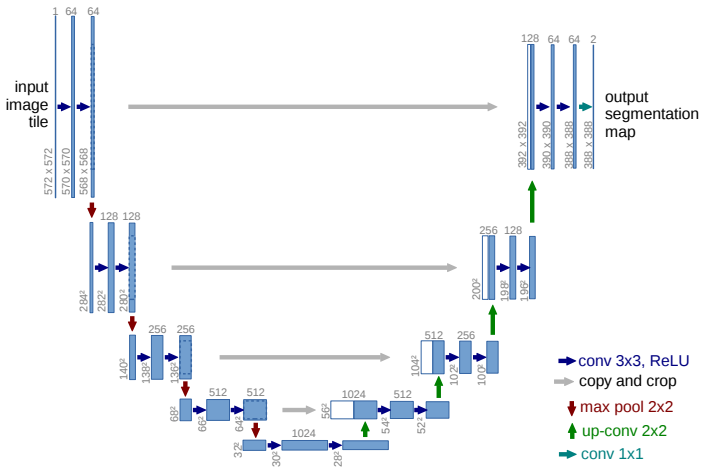

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                         ])
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ])
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2)# 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU()
                                         ])

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)# 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=1024 + 512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512 + 256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ])
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256 + 128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ])
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128 + 64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
                                         ])

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)# no activation
        return d3

In [ ]:
unet_model = UNet().to(device)
optim = torch.optim.Adam(unet_model.parameters(), lr=1e-4)


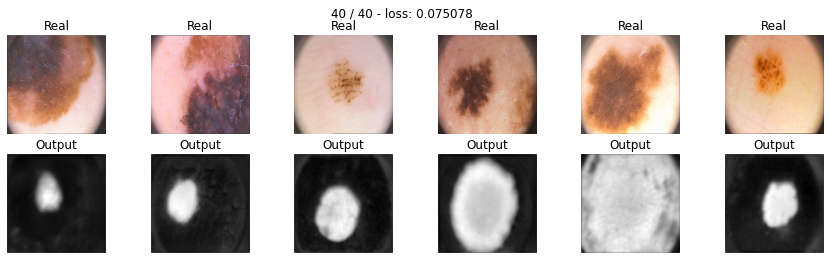

In [ ]:
train(unet_model, optim, bce_loss, 40, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.8635404706001282

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                         ])
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ])
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ])
        self.pool2 =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.pool3 =  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU()
                                         ])

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                         ])
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                         ])
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                         ])
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
                                         ])
        
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)

        
        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)# no activation
        
        return d3

In [ ]:
unet2_model = UNet2().to(device)
optim = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)


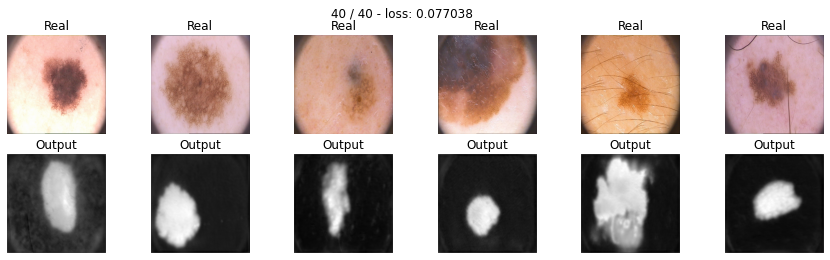

In [ ]:
train(unet2_model, optim, bce_loss, 40, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.842755526304245

Сделайте вывод, какая из моделей лучше (см отчет) 

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

## Отчет

Рассмотрим метрику IOU и лоссы: bce, focal, dice, tversky, hausdorff. Построим графики для них.

In [ ]:
import time
import copy
import seaborn as sns
import gc

In [ ]:
dataloaders = {}
dataloaders['train'], dataloaders['val'], dataloaders['test'] = data_tr, data_val, data_ts

In [ ]:
def train_new(model, optimizer, loss_fn, epochs, data):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_iou = 0.0
    
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_iou = []
    epoch_val_iou = []
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
    
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_iou = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    Y_pred = model(inputs)
                    loss = loss_fn(labels, Y_pred)
                    
                    # forward-pass
                    if phase == 'train':
                        loss.backward()  # backward-pass
                        optimizer.step()

                running_loss += loss.detach().item() * inputs.size(0)
                Y_pred = torch.sigmoid(Y_pred)
                Y_pred = torch.where(Y_pred > 0.5, 1, 0)
                running_iou += iou_pytorch(Y_pred, labels).mean().item()
                
            
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_iou = running_iou / len(dataloaders[phase])
            
            if phase == 'train':
                epoch_train_loss.append(epoch_loss)
                epoch_train_iou.append(epoch_iou)
            else:
                epoch_val_loss.append(epoch_loss)
                epoch_val_iou.append(epoch_iou)
                
            
            if phase == 'val':
                Y_pred = Y_pred.detach().cpu()
                clear_output(wait=True)
                for k in range(5):
                    plt.subplot(2, 5, k+1)
                    plt.imshow(np.rollaxis(inputs[k].cpu().numpy(), 0, 3), cmap='gray')
                    plt.title('Real', fontsize=12)
                    
                    plt.axis('off')

                    plt.subplot(2, 5, k+6)
                    plt.imshow(Y_pred[k, 0], cmap='gray')
                    plt.title('Output', fontsize=12)
                    plt.axis('off')
                plt.suptitle('val Loss: {:.4f} val IOU: {:.4f}'.format(epoch_loss, epoch_iou), fontsize=15)
                plt.show()
                
            inputs, labels = inputs.cpu(), labels.cpu()
            Y_pred, loss = Y_pred.cpu(), loss.cpu()
            del inputs, labels, Y_pred, loss, 
            torch.cuda.empty_cache()
            gc.collect()
            
            
            if phase == 'val' and epoch_iou > best_iou:
                best_iou = epoch_iou
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val IOU: {:4f}'.format(best_iou))
    
    
    model.load_state_dict(best_model_wts)
    statistics = epoch_train_loss, epoch_train_iou, epoch_val_loss, epoch_val_iou
    return model, statistics

###Модель Segnet

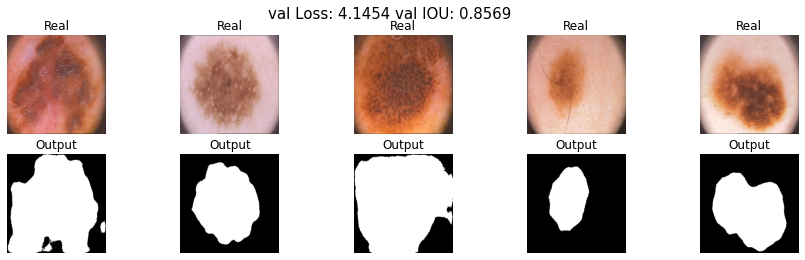


Training complete in 4m 0s
Best val IOU: 0.866074


In [ ]:
model_bce = SegNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(model_bce.parameters(), lr=1e-4) 
segnet_best_model_bce, segnet_statistics_with_bce_loss = train_new(model_bce, optim, bce_loss, max_epochs, dataloaders)

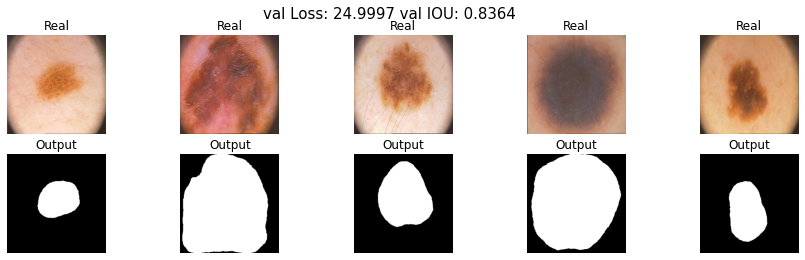


Training complete in 3m 57s
Best val IOU: 0.836366


In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
segnet_best_model_dice, segnet_statistics_with_dice_loss = train_new(model_dice, optimizer, dice_loss, 
                                                                     max_epochs, dataloaders)

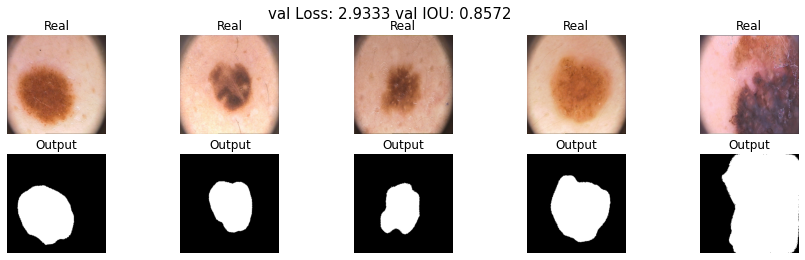


Training complete in 3m 53s
Best val IOU: 0.870036


In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimizer = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
segnet_best_model_focal, segnet_statistics_with_focal_loss = train_new(model_focal, optimizer, 
                                                                       focal_loss, max_epochs, dataloaders)

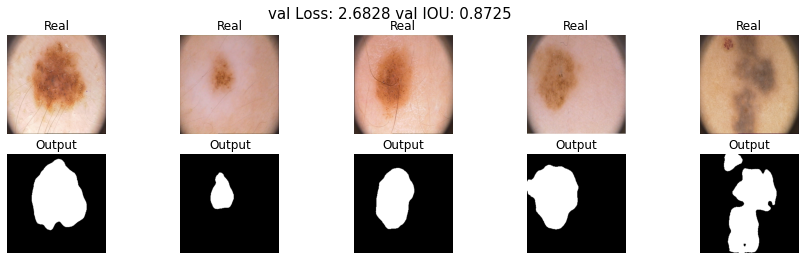


Training complete in 3m 52s
Best val IOU: 0.875028


In [ ]:
model_tversky = SegNet().to(device)

max_epochs = 40
optimizer = torch.optim.Adam(model_tversky.parameters(), lr=1e-4)
tversky_loss = BinaryTverskyLossV2()
segnet_best_model_tversky, segnet_statistics_with_tversky_loss = train_new(model_tversky, optimizer, tversky_loss, 
                                                        max_epochs, dataloaders)

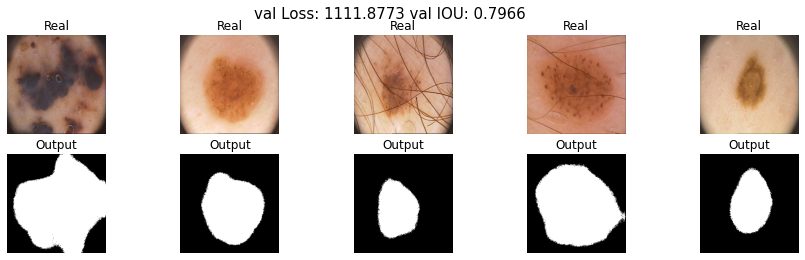


Training complete in 6m 20s
Best val IOU: 0.815168


In [ ]:
model_hausdor = SegNet().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(model_hausdor.parameters(), lr=1e-4)
hausdor_loss = HausdorffDTLoss()
segnet_best_model_hausdor, segnet_statistics_with_hausdor_loss = train_new(model_hausdor, optimizer, 
                                                                           hausdor_loss, max_epochs, dataloaders)

In [ ]:
train_stat_loss_segnet = [segnet_statistics_with_bce_loss[0], segnet_statistics_with_dice_loss[0], 
                          segnet_statistics_with_focal_loss[0], segnet_statistics_with_tversky_loss[0], segnet_statistics_with_hausdor_loss[0]]
train_stat_iou_segnet = [segnet_statistics_with_bce_loss[1], segnet_statistics_with_dice_loss[1], 
                          segnet_statistics_with_focal_loss[1], segnet_statistics_with_tversky_loss[1], 
                         segnet_statistics_with_hausdor_loss[1]]
val_stat_loss_segnet = [segnet_statistics_with_bce_loss[2], segnet_statistics_with_dice_loss[2], 
                          segnet_statistics_with_focal_loss[2], segnet_statistics_with_tversky_loss[2], segnet_statistics_with_hausdor_loss[2]]
val_stat_iou_segnet = [segnet_statistics_with_bce_loss[3], segnet_statistics_with_dice_loss[3], 
                          segnet_statistics_with_focal_loss[3], segnet_statistics_with_tversky_loss[3],
                      segnet_statistics_with_hausdor_loss[3]]

###Модель U-Net

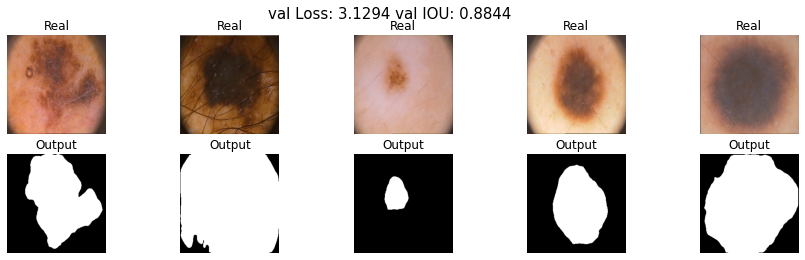


Training complete in 4m 53s
Best val IOU: 0.885080


In [ ]:
unet_model_bce = UNet().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(unet_model_bce.parameters(), lr=1e-4)
unet_best_model_bce, unet_statistics_with_bce_loss = train_new(unet_model_bce, 
                                                               optimizer, bce_loss, max_epochs, dataloaders)

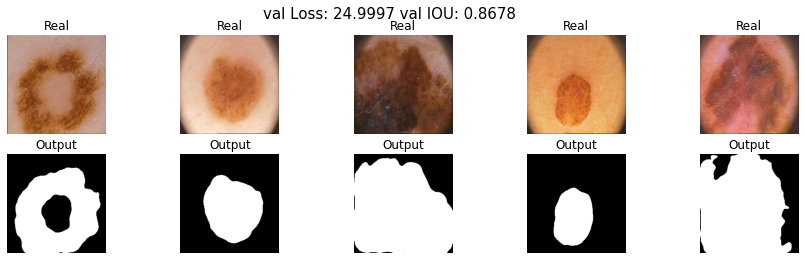


Training complete in 4m 53s
Best val IOU: 0.874937


In [ ]:
unet_model_dice = UNet().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(unet_model_dice.parameters(), lr=1e-4)
unet_best_model_dice, unet_statistics_with_dice_loss = train_new(unet_model_dice, 
                                                                 optimizer, dice_loss, max_epochs, dataloaders)

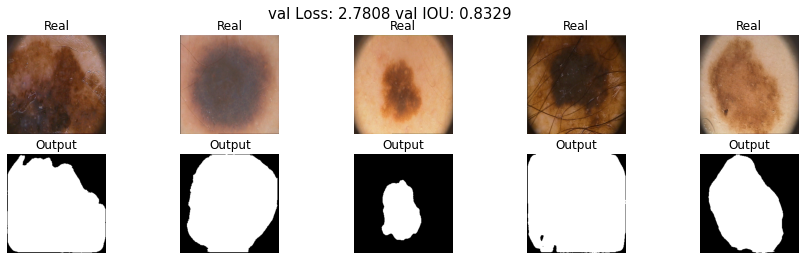


Training complete in 4m 57s
Best val IOU: 0.870680


In [ ]:
unet_model_focal = UNet().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(unet_model_focal.parameters(), lr=1e-4)
unet_best_model_focal, unet_statistics_with_focal_loss = train_new(unet_model_focal, 
                                                                   optimizer, focal_loss, max_epochs, dataloaders)                                                                  


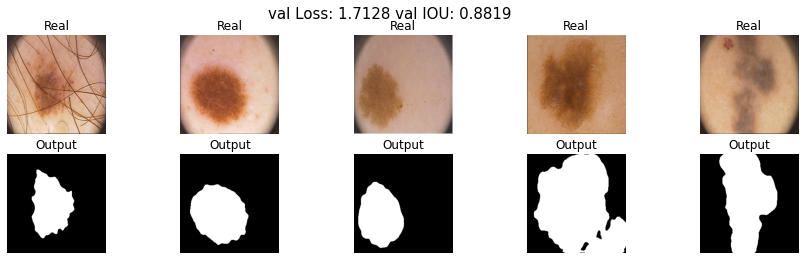


Training complete in 4m 58s
Best val IOU: 0.881876


In [ ]:
unet_model_tversky = UNet().to(device)

max_epochs = 40
optimizer = torch.optim.Adam(unet_model_tversky.parameters(), lr=1e-4)
tversky_loss = BinaryTverskyLossV2()
unet_best_model_tversky, unet_statistics_with_tversky_loss = train_new(unet_model_tversky, 
                                                                       optimizer, tversky_loss, max_epochs, dataloaders)

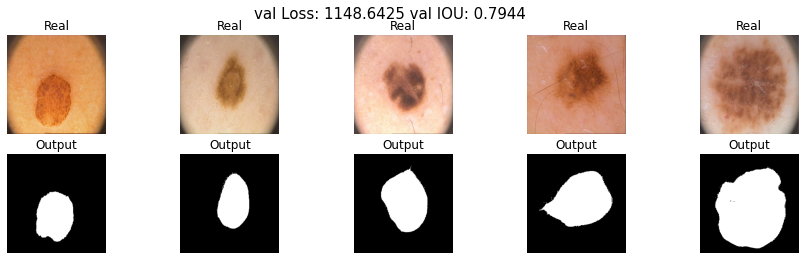


Training complete in 7m 34s
Best val IOU: 0.822688


In [ ]:
unet_model_hausdor = UNet().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(unet_model_hausdor.parameters(), lr=1e-4)
hausdor_loss = HausdorffDTLoss()
unet_best_model_hausdor, unet_statistics_with_hausdor_loss = train_new(unet_model_hausdor, 
                                                                       optimizer, hausdor_loss, max_epochs, dataloaders)

In [ ]:
train_stat_loss_unet = [unet_statistics_with_bce_loss[0], unet_statistics_with_dice_loss[0], 
                          unet_statistics_with_focal_loss[0], unet_statistics_with_tversky_loss[0], unet_statistics_with_hausdor_loss[0]]
train_stat_iou_unet = [unet_statistics_with_bce_loss[1], unet_statistics_with_dice_loss[1], 
                          unet_statistics_with_focal_loss[1], unet_statistics_with_tversky_loss[1], 
                         unet_statistics_with_hausdor_loss[1]]
val_stat_loss_unet = [unet_statistics_with_bce_loss[2], unet_statistics_with_dice_loss[2], 
                          unet_statistics_with_focal_loss[2], unet_statistics_with_tversky_loss[2], unet_statistics_with_hausdor_loss[2]]
val_stat_iou_unet = [unet_statistics_with_bce_loss[3], unet_statistics_with_dice_loss[3], 
                          unet_statistics_with_focal_loss[3], unet_statistics_with_tversky_loss[3],
                      unet_statistics_with_hausdor_loss[3]]

###Модель U-Net v2

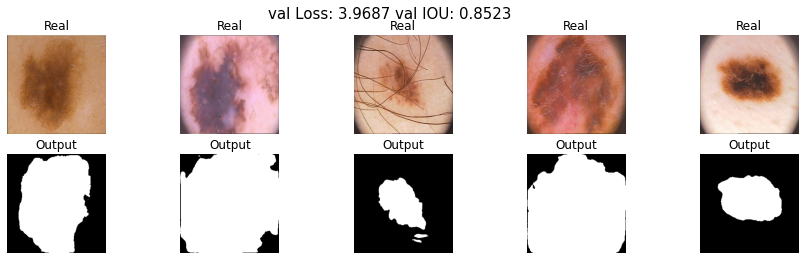


Training complete in 4m 43s
Best val IOU: 0.868107


In [ ]:
unet2_model_bce = UNet2().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(unet2_model_bce.parameters(), lr=1e-4)
unet2_best_model_bce, unet2_statistics_with_bce_loss = train_new(unet2_model_bce, 
                                                                 optimizer, bce_loss, max_epochs, dataloaders)

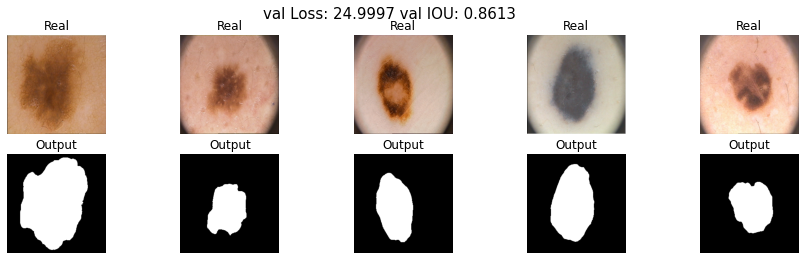


Training complete in 4m 43s
Best val IOU: 0.861321


In [ ]:
unet2_model_dice = UNet2().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(unet2_model_dice.parameters(), lr=1e-4)
unet2_best_model_dice, unet2_statistics_with_dice_loss = train_new(unet2_model_dice, 
                                                                   optimizer, dice_loss, max_epochs, dataloaders)

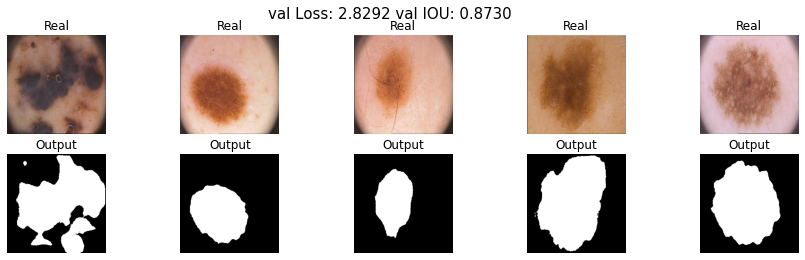


Training complete in 4m 42s
Best val IOU: 0.872969


In [ ]:
unet2_model_focal = UNet2().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(unet2_model_focal.parameters(), lr=1e-4)
unet2_best_model_focal, unet2_statistics_with_focal_loss = train_new(unet2_model_focal, 
                                                                     optimizer, focal_loss, max_epochs, dataloaders)

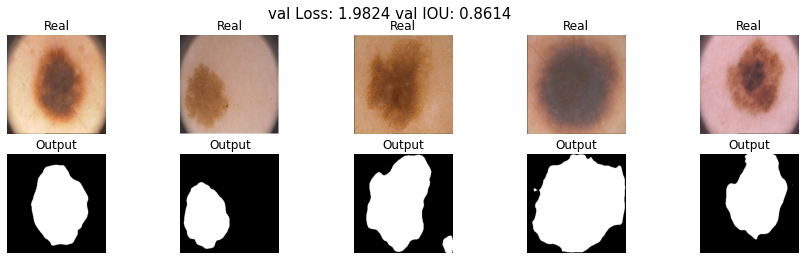


Training complete in 4m 42s
Best val IOU: 0.873471


In [ ]:
unet2_model_tversky = UNet2().to(device)

max_epochs = 40
optimizer = torch.optim.Adam(unet2_model_tversky.parameters(), lr=1e-4)
tversky_loss = BinaryTverskyLossV2()
unet2_best_model_tversky, unet2_statistics_with_tversky_loss = train_new(unet2_model_tversky, 
                                                                         optimizer, tversky_loss, max_epochs, dataloaders)

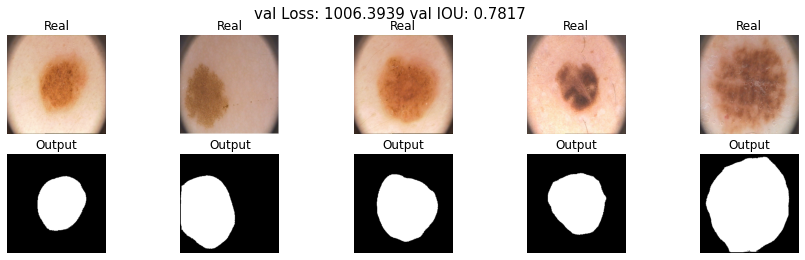


Training complete in 7m 3s
Best val IOU: 0.805883


In [ ]:
unet2_model_hausdor = UNet2().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(unet2_model_hausdor.parameters(), lr=1e-4)
hausdor_loss = HausdorffDTLoss()
unet2_best_model_hausdor, unet2_statistics_with_hausdor_loss = train_new(unet2_model_hausdor, 
                                                                         optimizer, hausdor_loss, max_epochs, dataloaders)

In [ ]:
train_stat_loss_unet2 = [unet2_statistics_with_bce_loss[0], unet2_statistics_with_dice_loss[0], 
                          unet2_statistics_with_focal_loss[0], unet2_statistics_with_tversky_loss[0], unet2_statistics_with_hausdor_loss[0]]
train_stat_iou_unet2 = [unet2_statistics_with_bce_loss[1], unet2_statistics_with_dice_loss[1], 
                          unet2_statistics_with_focal_loss[1], unet2_statistics_with_tversky_loss[1], 
                         unet2_statistics_with_hausdor_loss[1]]
val_stat_loss_unet2 = [unet2_statistics_with_bce_loss[2], unet2_statistics_with_dice_loss[2], 
                          unet2_statistics_with_focal_loss[2], unet2_statistics_with_tversky_loss[2], unet2_statistics_with_hausdor_loss[2]]
val_stat_iou_unet2 = [unet2_statistics_with_bce_loss[3], unet2_statistics_with_dice_loss[3], 
                          unet2_statistics_with_focal_loss[3], unet2_statistics_with_tversky_loss[3],
                      unet2_statistics_with_hausdor_loss[3]]

###Графики

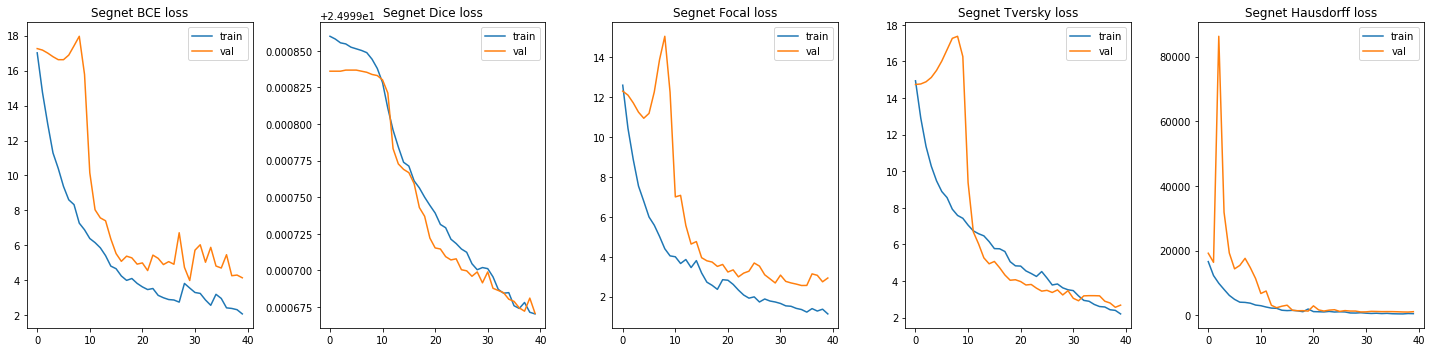

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
axe = ax.ravel()
losses = ['BCE', 'Dice', 'Focal', 'Tversky', 'Hausdor']
for num, (train, val, loss) in enumerate(zip(train_stat_loss_segnet, val_stat_loss_segnet, losses)):
    axe[num].plot(range(max_epochs), train, label=f'train')
    axe[num].plot(range(max_epochs), val, label=f'val')
    axe[num].set_title(f'Segnet {loss} loss')
    axe[num].legend()
plt.tight_layout()

Графики лоссов на Segnet показывают, что BCE и Focal лоссы начинают переобучаться с 20-25 эпохи. Dice, Tversky и Hausdorff можно дальше продолжать обучать.

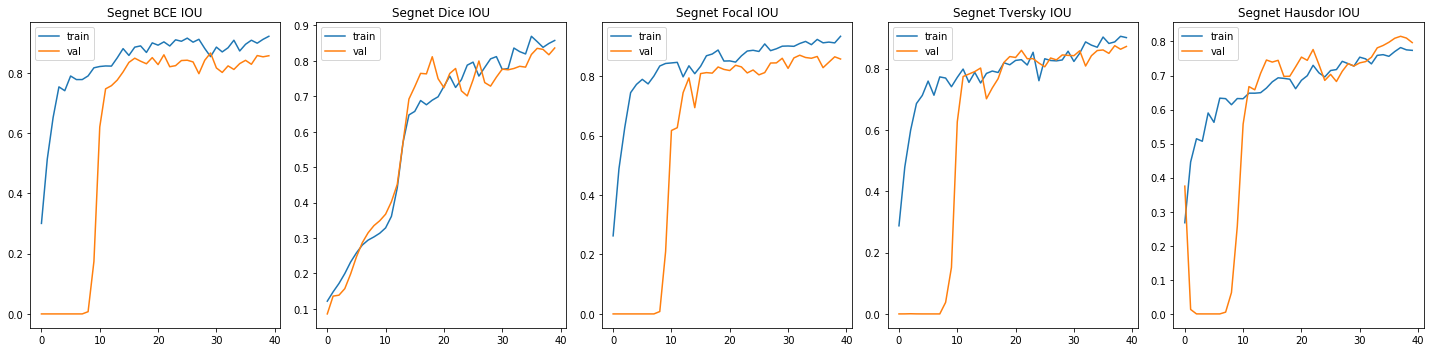

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
axe = ax.ravel()
losses_iou = ['BCE', 'Dice', 'Focal', 'Tversky', 'Hausdor']
for num, (train, val, loss) in enumerate(zip(train_stat_iou_segnet, val_stat_iou_segnet, losses_iou)):
    axe[num].plot(range(max_epochs), train, label=f'train')
    axe[num].plot(range(max_epochs), val, label=f'val')
    axe[num].set_title(f'Segnet {loss} IOU')
    axe[num].legend()
plt.tight_layout()

По графикам IOU на Segnet можно отметить неплохие результаты модели со всеми лоссами - свыше 0.8. Hausdorff немного отстает от остальных

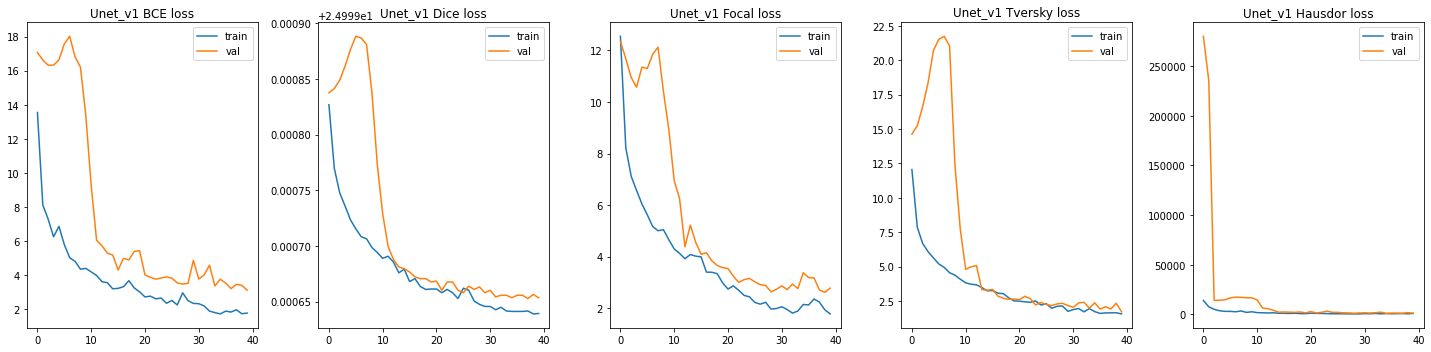

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
axe = ax.ravel()
losses = ['BCE', 'Dice', 'Focal', 'Tversky', 'Hausdor']
for num, (train, val, loss) in enumerate(zip(train_stat_loss_unet, val_stat_loss_unet, losses)):
    axe[num].plot(range(max_epochs), train, label=f'train')
    axe[num].plot(range(max_epochs), val, label=f'val')
    axe[num].set_title(f'Unet_v1 {loss} loss')
    axe[num].legend()
plt.tight_layout()

Аналогичная ситуация с лоссами BCE и Focal на графиках у модели U-Net.

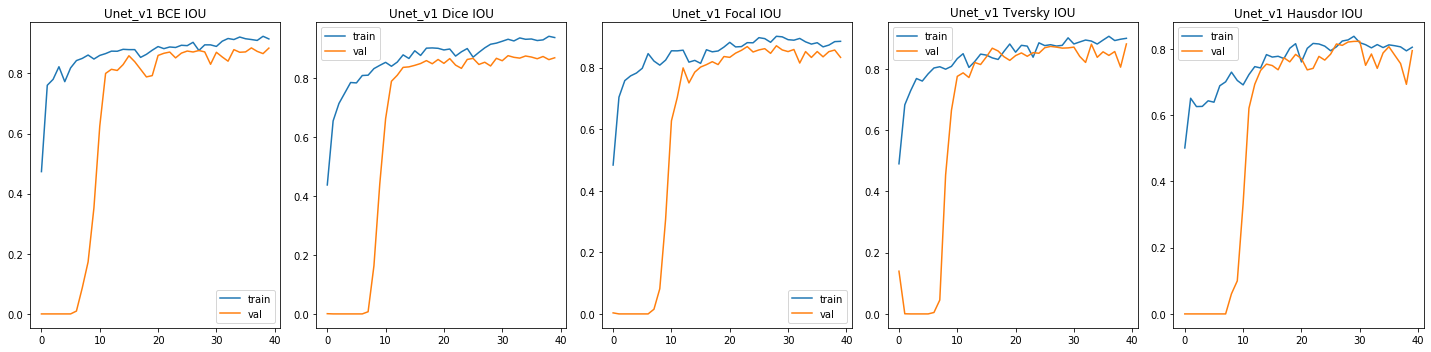

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
axe = ax.ravel()
losses_iou = ['BCE', 'Dice', 'Focal', 'Tversky', 'Hausdor']
for num, (train, val, loss) in enumerate(zip(train_stat_iou_unet, val_stat_iou_unet, losses_iou)):
    axe[num].plot(range(max_epochs), train, label=f'train')
    axe[num].plot(range(max_epochs), val, label=f'val')
    axe[num].set_title(f'Unet_v1 {loss} IOU')
    axe[num].legend()
plt.tight_layout()

Метрика IOU на U-Net стабильна у всех лоссов, кроме Hausdor. Показатели Hausdorff loss немного ниже остальных, показатели которых в свою очередь практически совпадают между собой.

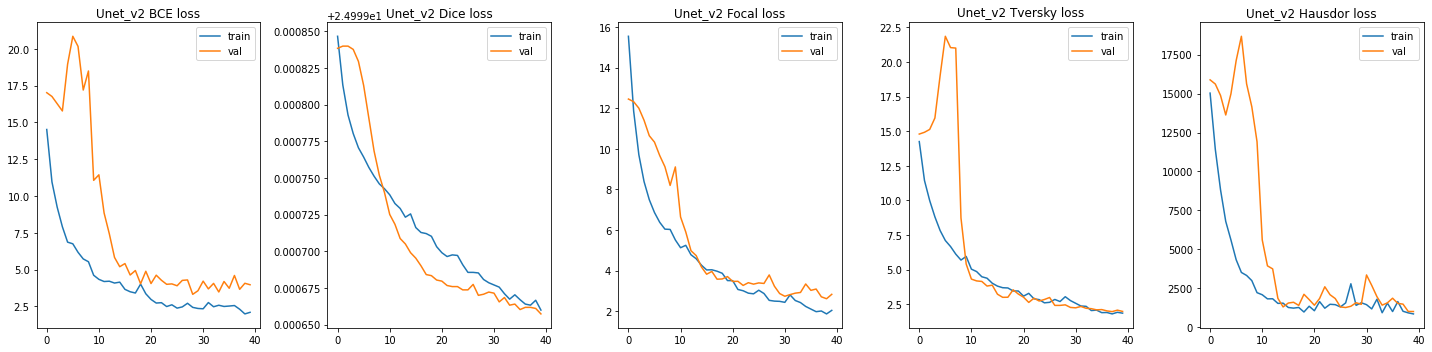

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
axe = ax.ravel()
losses = ['BCE', 'Dice', 'Focal', 'Tversky', 'Hausdor']
for num, (train, val, loss) in enumerate(zip(train_stat_loss_unet2, val_stat_loss_unet2, losses)):
    axe[num].plot(range(max_epochs), train, label=f'train')
    axe[num].plot(range(max_epochs), val, label=f'val')
    axe[num].set_title(f'Unet_v2 {loss} loss')
    axe[num].legend()
plt.tight_layout()

U-Net v2 - BCE и Focal лоссы рано переобучаются

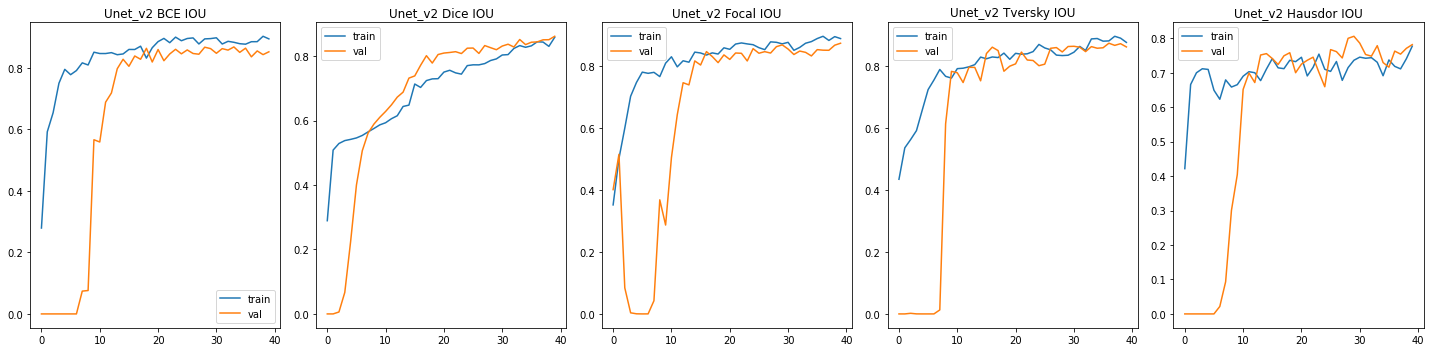

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
axe = ax.ravel()
losses_iou = ['BCE', 'Dice', 'Focal', 'Tversky', 'Hausdor']
for num, (train, val, loss) in enumerate(zip(train_stat_iou_unet2, val_stat_iou_unet2, losses_iou)):
    axe[num].plot(range(max_epochs), train, label=f'train')
    axe[num].plot(range(max_epochs), val, label=f'val')
    axe[num].set_title(f'Unet_v2 {loss} IOU')
    axe[num].legend()
plt.tight_layout()

U-Net v2 - показатели Hausforff все так же немного отстают от остальных

###Сравнение моделей по IOU для кажого лосса на валидационной выборке

In [ ]:
val_iou_bce = [segnet_statistics_with_bce_loss[3], unet_statistics_with_bce_loss[3], unet2_statistics_with_bce_loss[3]]
val_iou_dice = [segnet_statistics_with_dice_loss[3], unet_statistics_with_dice_loss[3], unet2_statistics_with_dice_loss[3]]
val_iou_focal = [segnet_statistics_with_focal_loss[3], unet_statistics_with_focal_loss[3], unet2_statistics_with_focal_loss[3]]
val_iou_tversky = [segnet_statistics_with_tversky_loss[3], unet_statistics_with_tversky_loss[3], unet2_statistics_with_tversky_loss[3]]
val_iou_hausdor = [segnet_statistics_with_hausdor_loss[3], unet_statistics_with_hausdor_loss[3], unet2_statistics_with_hausdor_loss[3]]

In [ ]:
val_iou_segnet = [segnet_statistics_with_bce_loss[3], segnet_statistics_with_dice_loss[3], 
                  segnet_statistics_with_focal_loss[3], segnet_statistics_with_tversky_loss[3],
                 segnet_statistics_with_hausdor_loss[3]]
val_iou_unet_v1 = [unet_statistics_with_bce_loss[3], unet_statistics_with_dice_loss[3], 
                  unet_statistics_with_focal_loss[3], unet_statistics_with_tversky_loss[3],
                 unet_statistics_with_hausdor_loss[3]]
val_iou_unet_v2 = [unet2_statistics_with_bce_loss[3], unet2_statistics_with_dice_loss[3], 
                  unet2_statistics_with_focal_loss[3], unet2_statistics_with_tversky_loss[3],
                 unet2_statistics_with_hausdor_loss[3]]

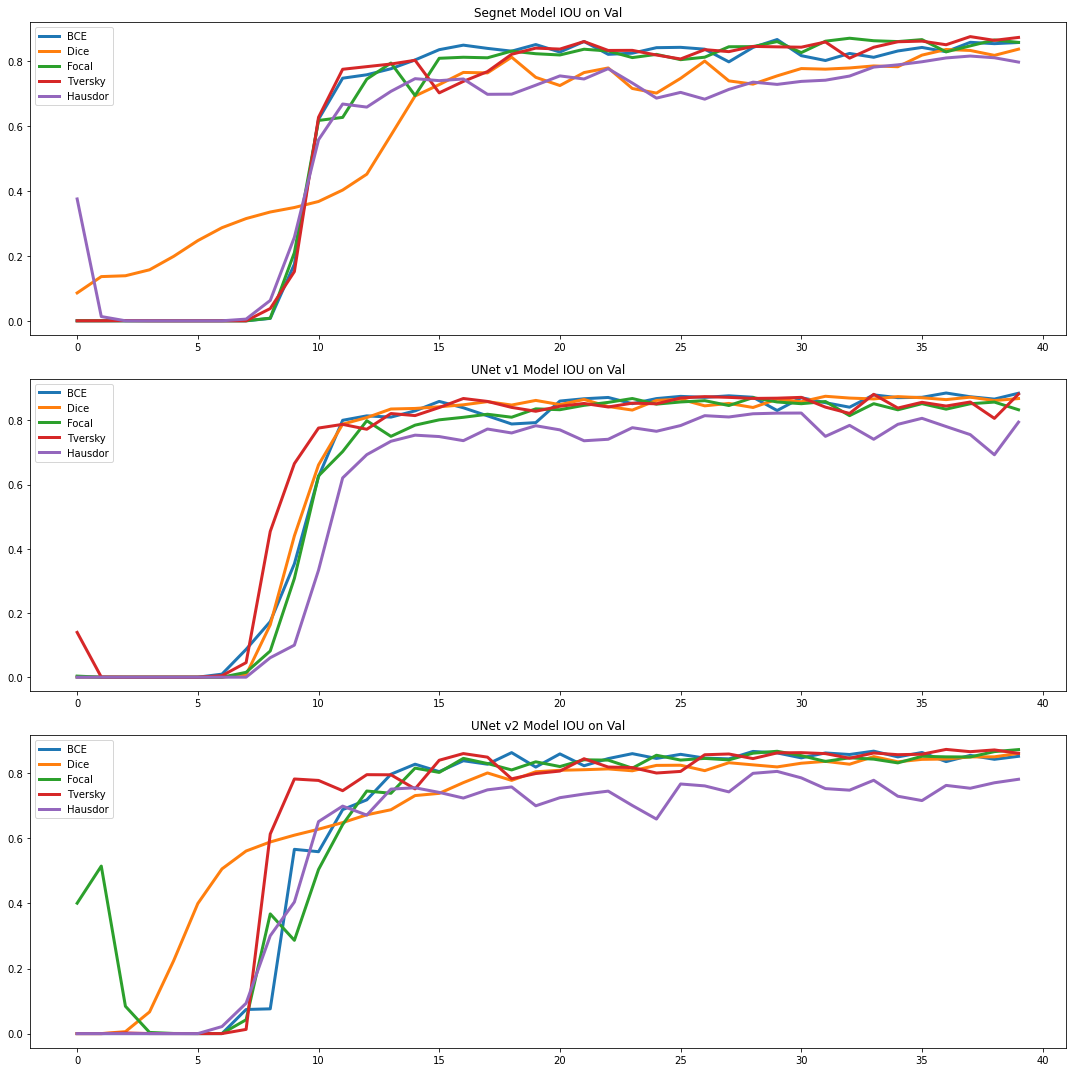

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
axe = ax.ravel()
models = ['Segnet', 'UNet v1', 'UNet v2']
for num, (bce, dice, focal, tversky, hausdor, model) in enumerate(zip(val_iou_bce, val_iou_dice, val_iou_focal,
                                                                   val_iou_tversky, val_iou_hausdor, models)):
    axe[num].plot(range(max_epochs), bce, label=f'BCE', linewidth=3)
    axe[num].plot(range(max_epochs), dice, label=f'Dice', linewidth=3)
    axe[num].plot(range(max_epochs), focal, label=f'Focal', linewidth=3)
    axe[num].plot(range(max_epochs), tversky, label=f'Tversky', linewidth=3)
    axe[num].plot(range(max_epochs), hausdor, label=f'Hausdor', linewidth=3)
    axe[num].set_title(f'{model} Model IOU on Val')
    axe[num].legend()
plt.tight_layout()

Во всех 3 моделях худшим лоссом оказалася Hausdorff loss. А вот лучшие лоссы у моделей разные.

Для Segnet - BCE/Focal (BCE совсем немного выше)
Для Unet v1 - Tversky loss.
Для Unet v2 - 1. Dice 2. Bce 3. Tversky (все рядышком по IOU) 

### Предикт на тестовой выборке моделей с наилучшим IOU на валидации, сравнение результатов по моделям/лоссам

In [ ]:
best_model_segnet_bce_test = score_model(segnet_best_model_bce, iou_pytorch, dataloaders['test'])
best_model_segnet_dice_test = score_model(segnet_best_model_dice, iou_pytorch, dataloaders['test'])
best_model_segnet_focal_test = score_model(segnet_best_model_focal, iou_pytorch, dataloaders['test'])
best_model_segnet_tversky_test = score_model(segnet_best_model_tversky, iou_pytorch, dataloaders['test'])
best_model_segnet_hausdor_test = score_model(segnet_best_model_hausdor, iou_pytorch, dataloaders['test'])

best_model_unet_bce_test = score_model(unet_best_model_bce, iou_pytorch, dataloaders['test'])
best_model_unet_dice_test = score_model(unet_best_model_dice, iou_pytorch, dataloaders['test'])
best_model_unet_focal_test = score_model(unet_best_model_focal, iou_pytorch, dataloaders['test'])
best_model_unet_tversky_test = score_model(unet_best_model_tversky, iou_pytorch, dataloaders['test'])
best_model_unet_hausdor_test = score_model(unet_best_model_hausdor, iou_pytorch, dataloaders['test'])

best_model_unet2_bce_test = score_model(unet2_best_model_bce, iou_pytorch, dataloaders['test'])
best_model_unet2_dice_test = score_model(unet2_best_model_dice, iou_pytorch, dataloaders['test'])
best_model_unet2_focal_test = score_model(unet2_best_model_focal, iou_pytorch, dataloaders['test'])
best_model_unet2_tversky_test = score_model(unet2_best_model_tversky, iou_pytorch, dataloaders['test'])
best_model_unet2_hausdor_test = score_model(unet2_best_model_hausdor, iou_pytorch, dataloaders['test'])

In [ ]:
import pandas as pd

In [ ]:
losses_iou

['BCE', 'Dice', 'Focal', 'Tversky', 'Hausdor']

In [ ]:
test_results = pd.DataFrame({'Segnet': [best_model_segnet_bce_test, best_model_segnet_dice_test, best_model_segnet_dice_test,
                        best_model_segnet_tversky_test, best_model_segnet_hausdor_test],
             'Unet_v1': [best_model_unet_bce_test, best_model_unet_dice_test, best_model_unet_focal_test,
                        best_model_unet_tversky_test, best_model_unet_hausdor_test],
             'Unet_v2': [best_model_unet2_bce_test, best_model_unet2_dice_test, best_model_unet2_focal_test,
                        best_model_unet2_tversky_test, best_model_unet2_hausdor_test]}, index=losses_iou)

In [ ]:
import matplotlib
matplotlib.__version__

'3.2.2'

In [ ]:
!pip install --upgrade matplotlib==3.4


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.3 MB 11.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
fig, ax = plt.subplots()
test_results.T.plot(kind='barh', figsize=(10, 10), width=0.6, title='', ax=ax)
ax.set_title('Comparison of IOU on 3 models with different losses')
ax.legend(loc='upper left')

# new helper method to auto-label bars
for i in range(len(losses_iou)):
    ax.bar_label(ax.containers[i], fmt='%.2f')

U-Net v1 в среднем по метрике IOU показал себя лучше Segnet и U-Net v2. Лучшие показатели у BCE и Tversky loss - практически одинаковое качество на U-Net v1, худший показатель во всех трех моделях у hausdorff loss.